# Orthocorrection of KH-5 ARGON images

The purpose of this notebook is to ortho correct Declassified Intelligence Satellite Photography (DISP) from the KH-5 ARGON missions. The images are loaded one by one and corrected using the functions provided in geometry.

In [1]:
import os
import posixpath
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import shutil
from osgeo import gdal, osr

# parallel computing
from dask.distributed import Client

# personnal packages
import utils.plots as plots
import utils.norm as norm
import utils.space_rejection as sr
import geometry.internal_orientation as io
import geometry.external_orientation as eo

# to keep xarray quiet
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
def set_env():
    os.environ["GS_NO_SIGN_REQUEST"] = "YES"

set_env()

client = Client(n_workers=1, threads_per_worker=4)
client.run(set_env)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 7.89 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61545,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:61553,Total threads: 4
Dashboard: http://127.0.0.1:61554/status,Memory: 7.89 GiB
Nanny: tcp://127.0.0.1:61548,


In [3]:
images_root = 'D:/OneDrive/Documents/Cours/4A/SFE/data/KH-5_ARGON_images'
products = []

for x in os.listdir(images_root):
    if os.path.isdir(posixpath.join(images_root, x)):
        products.append(x)
        
products

['DS09034A007MC018',
 'DS09034A007MC019',
 'DS09034A008MC019',
 'DS09034A008MC020',
 'DS09034A008MC021',
 'DS09034A008MC022',
 'DS09058A024MC012',
 'DS09058A024MC013']

# DS09058A024MC013

In [4]:
file = posixpath.join(images_root, "DS09058A024MC013", "DS09058A024MC013_a.tif")
raster = rioxarray.open_rasterio(file, chunks=True)
raster

c:\ProgramData\miniconda3\Lib\site-packages\rioxarray\_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray (band: 1, y: 19912, x: 19332)> Size: 385MB
dask.array<open_rasterio-890b347c846d082a08279604c8a0b0f9<this-array>, shape=(1, 19912, 19332), dtype=uint8, chunksize=(1, 6942, 19332), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 155kB 0.5 1.5 2.5 ... 1.933e+04 1.933e+04 1.933e+04
  * y            (y) float64 159kB 0.5 1.5 2.5 ... 1.991e+04 1.991e+04 1.991e+04
    spatial_ref  int32 4B 0
Attributes: (12/13)
    TIFFTAG_SOFTWARE:          Adobe Photoshop CC 2018 (Windows)
    TIFFTAG_DATETIME:          2019:12:03 22:13:38
    TIFFTAG_XRESOLUTION:       1432.3507
    TIFFTAG_YRESOLUTION:       1432.3507
    TIFFTAG_RESOLUTIONUNIT:    3 (pixels/cm)
    STATISTICS_APPROXIMATE:    YES
    ...                        ...
    STATISTICS_MEAN:           115.70980174446
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         99.755916419582
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0

In [5]:
shx, shy = raster.shape[1:]

## IO

### Image, fiducial and photo coordinates

In [6]:
FMs = pd.DataFrame(
    [
        # top left corner
        [989, 375],
        # left side
        [1005, 3263],
        [1004, 6147],
        [1006, 9043],
        [1000, 11921],
        [1004, 14811],
        # bottom left corner
        [1012, 17698],
        # bottom side
        [3890, 17703],
        [6768, 17694],
        [9659, 17698],
        [12534, 17704],
        [15420, 17701],
        # bottom right corner
        [18326, 17704],
        # right side
        [18304, 14812],
        [18309, 11924],
        [18315, 9030],
        [18313, 6157],
        [18313, 3273],
        # top right corner
        [18293, 381],
        # top side
        [15427, 378],
        [12544, 376],
        [9650, 378],
        # missing point here
        [3897, 375],
    ],
    columns = ['x', 'y'],
    index=list(range(1, 23)) + [24]
)

FMs.loc[1, "side"] = "NW"
FMs.loc[2:6, "side"] = "W"
FMs.loc[7, "side"] = "SW"
FMs.loc[8:12, "side"] = "S"
FMs.loc[13, "side"] = "SE"
FMs.loc[14:18, "side"] = "E"
FMs.loc[19, "side"] = "NE"
FMs.loc[20:24, "side"] = "N"

# cast as float
FMs = FMs.astype({"x": float, "y": float})

xiW = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("W")), "x"].mean() * 127/shx
etaS = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("S")), "y"].mean() * 127/shy
xiE = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("E")), "x"].mean() * 127/shx
etaN = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("N")), "y"].mean() * 127/shy

FMs.loc[FMs["side"].apply(lambda x: x.__contains__("W")), "xi"] = xiW
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("S")), "eta"] = etaS
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("E")), "xi"] = xiE
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("N")), "eta"] = etaN

delta_xi = (127 - xiW - (127 - xiE)) / 6
delta_eta = (127 - etaN - (127 - etaS)) /6

# FMs.loc[2:6, "eta"] = FMs.loc[2:6, "y"] * 127 / shy
# FMs.loc[8:12, "xi"] = FMs.loc[8:12, "x"] * 127 / shx
# FMs.loc[14:18, "eta"] = FMs.loc[14:18, "y"] * 127 / shy
# FMs.loc[20:24, "xi"] = FMs.loc[20:24, "x"] * 127 / shx

FMs.loc[2:6, "eta"] = etaN + delta_eta * np.array(range(1, 6))
FMs.loc[8:12, "xi"] = xiW + delta_xi * np.array(range(1, 6))
FMs.loc[14:18, "eta"] = etaN + delta_eta * np.array(range(5, 0, -1))
FMs.loc[20:24, "xi"] = xiW + delta_xi * np.array([5, 4, 3, 1]) # missing point here

FMs.head()

,x,y,side,xi,eta
1,989.0,375.0,NW,6.396287,2.477766
2,1005.0,3263.0,W,6.396287,21.444902
3,1004.0,6147.0,W,6.396287,40.412039
4,1006.0,9043.0,W,6.396287,59.379176
5,1000.0,11921.0,W,6.396287,78.346312


Text(0.5, 1.0, 'Fiducial coordinates [mm]')

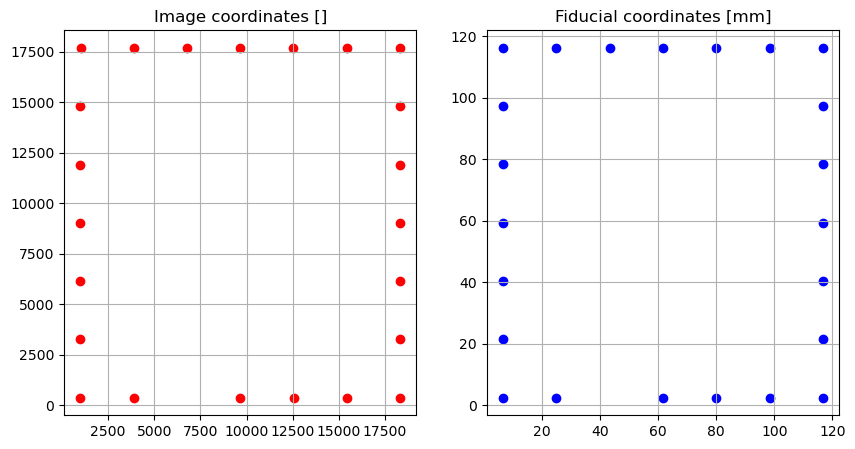

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].scatter(FMs.x, FMs.y, color='r')
axs[0].grid()
axs[0].set_title('Image coordinates []')
axs[1].scatter(FMs.xi, FMs.eta, color='b')
axs[1].grid()
axs[1].set_title('Fiducial coordinates [mm]')

In [8]:
# delta = 127./8

# FMs_fiducial_coords = np.array([
#     # [1, 1],
#     [1, 2],
#     [1, 3],
#     [1, 4],
#     [1, 5],
#     [1, 6],
#     # [1, 7],
#     [2, 7],
#     [3, 7],
#     [4, 7],
#     [5, 7],
#     [6, 7],
#     # [7, 7],
#     [7, 6],
#     [7, 5],
#     [7, 4],
#     [7, 3],
#     [7, 2],
#     # [7, 1],
#     [6, 1],
#     [5, 1],
#     [4, 1],
#     # [3, 1],
#     [2, 1],
# ]) * delta

# FMs_photo_coords = np.array(
#     [io.fiducial_to_photos_coordinates(FMs_fiducial_coords[i,  0], FMs_fiducial_coords[i, 1], 127/2, 127/2) for i in range(len(FMs_fiducial_coords))]
# )

In [9]:
# normalization
# cols = ['x', 'y', 'xi', 'eta', 'xp', 'yp']
# FMs.loc[:, cols], mins_FMs, maxs_FMs= norm.normalize(FMs.loc[:, cols])
# FMs.head()

### Transformation parameters
Finally, the image to fiducial coordinates transformation parameters are retrieved via an optimization process.
Several transformations and optimization methods are tested:

#### 1. the affine transformation described in Molnar et al. (2021):
$$
\begin{pmatrix}
\xi\\
\eta
\end{pmatrix} = \begin{pmatrix}
\delta\xi\cos\alpha & \delta\eta\sin\alpha\\
-\delta\xi\sin\alpha & \delta\eta\cos\alpha
\end{pmatrix} \begin{pmatrix}
x - x_c\\
y - y_c
\end{pmatrix}
$$


where:
- $\xi$ and $\eta$ are the fiducial coordinates
- $x$ and $y$ are the image coordinates
- $\alpha$ is an angle
- $\delta\xi$ and $\delta\eta$ are the pixel size
- $x_c$ and $y_c$ are the location of the image coordinates system center.

The transformation is linear but the relation with the parameters is not (especially $\alpha$). Therefore, several optimization techniques are tested; the only satisfactory one is the Nelder-Mead algorithm (simplex).


     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 3.173e-02]
           x: [ 1.568e-13  7.964e-14 -1.445e-09  6.378e-03  6.570e-03]
        cost: 0.0005035296209124555
         jac: [[-1.752e-04 -1.314e-04  8.746e-01  1.232e+01  6.427e+00]]
        grad: [-5.559e-06 -4.169e-06  2.775e-02  3.911e-01  2.039e-01]
  optimality: 0.3910964181779632
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 19
        njev: 5
----------------------------------------------
|  xc  |  yc  | alpha | delta_eta | delta_xi |
| 0.00 | 0.00 | 0.00 | 0.01 | 0.01 |
| 0.00 | 0.00 | -0.00 | 0.01 | 0.01 |
----------------------------------------------


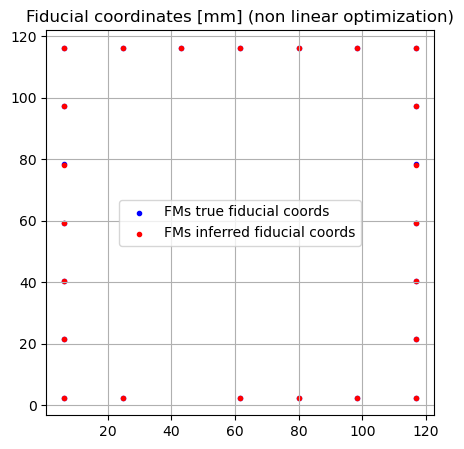

In [10]:
res = opt.least_squares(
    io.objective_function,
    x0=[0, 0, 0, 127/shx, 127/shy],
    args=(FMs.loc[:, ("xi", "eta")].to_numpy(), FMs.loc[:, ("x", "y")].to_numpy()),
    method="trf",
    # x_scale="jac",
    max_nfev=1000
)
# res = opt.minimize(
#     io.objective_function_molnar,
#     x0=[0, 0, 0, 127/shx, 127/shy],
#     args=(FMs.loc[:, ("xi", "eta")].to_numpy(), FMs.loc[:, ("x", "y")].to_numpy()),
#     method="Nelder-mead",
#     options={"maxiter": 1000},
# )
print(res)

if res.success:
    params = res.x

    xc, yc, alpha, delta_eta, delta_xi = params[0], params[1], params[2], params[3], params[4]
    print("----------------------------------------------")
    print("|  xc  |  yc  | alpha | delta_eta | delta_xi |") 
    print("| {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} |".format(0., 0., 0., 127/shx, 127/shy)) 
    print("| {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} |".format(xc, yc, alpha, delta_eta, delta_xi))
    print("----------------------------------------------")

    
    xi, eta = io.image_to_fiducial_coordinates(FMs.loc[:, "x"].values, FMs.loc[:, "y"].values, xc, yc, alpha, delta_eta, delta_xi)
    FMs_inferred_fiducial_coords = np.array([xi, eta]).T
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(FMs.xi, FMs.eta, marker=".", color="b", label='FMs true fiducial coords')
    ax.scatter(FMs_inferred_fiducial_coords[:, 0], FMs_inferred_fiducial_coords[:, 1], marker=".", color="r", label='FMs inferred fiducial coords')
    ax.grid()
    ax.legend()
    ax.set_title("Fiducial coordinates [mm] (non linear optimization)")

#### 2. A linear transformation of the plane:
$$
\begin{pmatrix}
\xi\\
\eta
\end{pmatrix} = \begin{pmatrix}
m_{11} & m_{12} \\
m_{21}  & m_{22} 
\end{pmatrix} \begin{pmatrix}
x\\
y
\end{pmatrix}
$$

Where:
- $\xi$ and $\eta$ are the fiducial coordinates
- $x$ and $y$ are the image coordinates
- $m_{11}\cdots m_{22}$ are a matrix coefficients.

This time, the relation between the parameters is fully linear, and allows for a linear least squares regression. Unfortunately, this method does not give good results (probably due to ill-conditioning), even with a Tikhonov regularization. Iterative methods, such as BFGS or Nelder-Mead are satisfactory.  

In [11]:
# res = opt.minimize(
#     io.objective_function_linear,
#     x0=[127/shx, 0, 0, 127/shy],
#     args=(FMs.loc[:, ("xi", "eta")].to_numpy(), FMs.loc[:, ("x", "y")].to_numpy()),
#     method='Nelder-mead',
#     options={"maxiter": 1000},
# )

# if res.success:
#     matrix = res.x
#     matrix = np.array([
#         [matrix[0], matrix[1]],
#         [matrix[2], matrix[3]]
#     ])
#     print(matrix)
    
#     xi, eta = io.image_to_fiducial_coordinates_linear(FMs.loc[:, "x"].values, FMs.loc[:, "y"].values, matrix)
#     FMs_fiducial_inferred_coords = np.array([xi, eta]).T

#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax.scatter(FMs.xi, FMs.eta, marker=".", color="b", label='FMs true fiducial coords')
#     ax.scatter(FMs_inferred_fiducial_coords[:, 0], FMs_inferred_fiducial_coords[:, 1], marker=".", color="r", label='FMs inferred fiducial coords')
#     ax.grid()
#     ax.legend()
#     ax.set_title("Fiducial coordinates [mm] (linear optimization)")
# else:
#     print(res)

#### 3. An affine transformation of the plane:
$$
\begin{pmatrix}
\xi\\
\eta
\end{pmatrix} = \begin{pmatrix}
m_{11} & m_{12} \\
m_{21}  & m_{22} 
\end{pmatrix} \begin{pmatrix}
x\\
y
\end{pmatrix} + \begin{pmatrix}
x_t\\
y_t
\end{pmatrix}
$$

Where:
- $\xi$ and $\eta$ are the fiducial coordinates
- $x$ and $y$ are the image coordinates
- $m_{11}\cdots m_{22}$ are a matrix coefficients.
- $x_t$ and $y_t$ are a translation vector coefficients.

The inverse problem is solved using an iterative optimization method.  

In [12]:
# res = opt.minimize(
#     io.objective_function_affine,
#     x0=[127/shx, 0, 0, 127/shy, 0, 0],
#     args=(FMs.loc[:, ("xi", "eta")].to_numpy(), FMs.loc[:, ("x", "y")].to_numpy()),
#     method='Nelder-mead',
#     options={"maxiter": 1000},
# )
# # res = opt.least_squares(
# #     io.objective_function_affine,
# #     x0=[127/shx, 0, 0, 127/shy, 0, 0],
# #     args=(FMs_fiducial_coords, FMs_image_coords),
# # )


# if res.success:
#     m11, m12, m21, m22, t1, t2 = res.x
#     matrix = np.array([
#         [m11, m12],
#         [m21, m22]
#     ])
#     print(matrix)
#     translation = np.array([[t1], [t2]])
#     print(translation)

#     # FMs_inferred_fiducial_coords = np.array([
#     #     io.image_to_fiducial_coordinates_affine(FMs.loc[i, "x"], FMs.loc[i, "y"], matrix, translation) for i in FMs.index
#     # ])
#     xi, eta = io.image_to_fiducial_coordinates_affine(FMs.loc[:, "x"].values, FMs.loc[:, "y"].values, matrix, translation)
#     FMs_fiducial_inferred_coords = np.array([xi, eta]).T
    
#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax.scatter(FMs.xi, FMs.eta, marker=".", color="b", label='FMs true fiducial coords')
#     ax.scatter(FMs_inferred_fiducial_coords[:, 0], FMs_inferred_fiducial_coords[:, 1], marker=".", color="r", label='FMs inferred fiducial coords')
#     ax.grid()
#     ax.legend()
#     ax.set_title("Fiducial coordinates [mm] (affine optimization)")
# else:
#     print(res)

## EO

### GCPs loading and coordinates processing

1. GCPs identified in QGIS are loaded

In [13]:
file = posixpath.join(images_root, "DS09058A024MC013", "GCP.points")
GCPs = pd.read_csv(file, encoding="windows-1252", skiprows=1)
GCPs.columns = ["lon", "lat", "x_img", "y_img", "enable", "dX", "dY", "residual"]
GCPs.drop(columns=["enable", "dX", "dY", "residual"], inplace=True)
GCPs.loc[:, "y_img"] = - GCPs.loc[:, "y_img"]

GCPs.head()

,lon,lat,x_img,y_img
0,15.128475,78.601919,9349.420744,12890.485362
1,16.290948,78.456399,9129.475133,11877.442688
2,15.244772,78.652644,9150.510645,12962.811491
3,13.919246,78.225096,11012.550796,12580.251309
4,16.847492,78.385263,9023.237853,11391.559466


2. The elevation is added from the NPI 20m resolution DEM, and the converted coordinates in others coordinate systems are added.

In [14]:
# # loading and reprojecting in EPSG4326 the DEM
# DEM_root = 'D:/OneDrive/Documents/Cours/4A/SFE/data/NPI_DEMs/NP_S0_DTM20'
# file = posixpath.join(DEM_root, "S0_DTM20.tif")
# with rasterio.open(file) as src:
#     with rasterio.vrt.WarpedVRT(src, crs="EPSG:4326") as vrt:
#         DEM = rioxarray.open_rasterio(vrt)
#         DEM = DEM.rename({"x": "lon", "y": "lat"})
#         print(DEM.rio.crs)
        
#         h = DEM.interp(lon=("z", GCPs.lon), lat=("z", GCPs.lat), method="linear", kwargs={"fill_value": "extrapolate"})

In [15]:
DEM_root = 'D:/OneDrive/Documents/Cours/4A/SFE/data/NPI_DEMs/NP_S0_DTM20'
file = posixpath.join(DEM_root, "S0_DTM20_EPSG4326.tif")

DEM = rioxarray.open_rasterio(file, chunks=True)
DEM = DEM.rename({"x": "lon", "y": "lat"})
DEM.rio.set_nodata(0., inplace=True)
DEM = DEM.where(DEM < 3e38, 0.)
DEM

<xarray.DataArray (band: 1, lat: 15890, lon: 56948)> Size: 4GB
dask.array<where, shape=(1, 15890, 56948), dtype=float32, chunksize=(1, 5760, 5760), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 4B 1
  * lon          (lon) float64 456kB 9.498 9.498 9.499 ... 33.84 33.84 33.84
  * lat          (lat) float64 127kB 80.87 80.87 80.87 ... 74.08 74.08 74.07
    spatial_ref  int32 4B 0
Attributes: (12/15)
    RepresentationType:        ATHEMATIC
    STATISTICS_COVARIANCES:    34445.33087394282
    STATISTICS_MAXIMUM:        1629.8674316406
    STATISTICS_MEAN:           75.107037767815
    STATISTICS_MEDIAN:         -0,920757
    STATISTICS_MINIMUM:        -0.79490000009537
    ...                        ...
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_VALID_PERCENT:  72.84
    _FillValue:                3.4e+38
    scale_factor:              1.0
    add_offset:                0.0

In [16]:
h = DEM.interp(lat=("z", GCPs.lat.values), lon=("z", GCPs.lon.values), method="nearest").compute()
GCPs.loc[:, "h"] = h.values.reshape(-1)
GCPs = GCPs.loc[:, ["lon", "lat", "h", "x_img", "y_img"]]
GCPs.head()

,lon,lat,h,x_img,y_img
0,15.128475,78.601919,2.103760,9349.420744,12890.485362
1,16.290948,78.456399,0.000000,9129.475133,11877.442688
2,15.244772,78.652644,0.000000,9150.510645,12962.811491
3,13.919246,78.225096,0.000000,11012.550796,12580.251309
4,16.847492,78.385263,0.484778,9023.237853,11391.559466


In [17]:
# geocentric cartesian coordinates
x_geo, y_geo, z_geo = eo.geodetic_to_geocentric_cartesian_coordinates(GCPs.lat.values *np.pi/180, GCPs.lon.values *np.pi/180, GCPs.h.values)
GCPs.loc[:, ["x_geo", "y_geo", "z_geo"]] = np.array([x_geo, y_geo, z_geo]).T

# local cartesian coordinates
lat_c, lon_c = 77.75936, 18.40797
x_gr, y_gr, z_gr = eo.geocentric_cartesian_to_local_cartesian_coordinates(x_geo, y_geo, z_geo, lat_c *np.pi/180, lon_c *np.pi/180)
GCPs.loc[:, ["x_gr", "y_gr", "z_gr"]] = np.array([x_gr, y_gr, z_gr]).T

# fiducial coordinates
xi, eta = io.image_to_fiducial_coordinates(GCPs.x_img.values, GCPs.y_img.values, xc, yc, alpha, delta_eta, delta_xi)
GCPs.loc[:, ["xi", "eta"]] = np.array([xi, eta]).T

GCPs.describe(percentiles=[])

,lon,lat,h,x_img,y_img,x_geo,y_geo,z_geo,x_gr,y_gr,z_gr,xi,eta
count,49.000000,49.000000,49.000000,49.000000,49.000000,4.900000e+01,49.000000,4.900000e+01,49.000000,49.000000,49.000000,49.000000,49.000000
mean,16.325678,78.327924,553.059937,9360.893932,11519.849023,1.239991e+06,365414.859499,6.224611e+06,-44848.374287,66041.471626,-702.992140,59.706946,75.681963
std,3.013887,0.635855,418.364716,1492.687102,3002.830087,5.490562e+04,81649.187286,1.481421e+04,70092.909433,70613.653136,1171.985377,9.520863,19.727696
min,11.453661,76.443669,0.000000,6226.971963,1657.784748,1.149893e+06,245327.596225,6.178518e+06,-153824.610495,-137364.531531,-3739.298504,39.717732,10.891150
50%,16.452674,78.431191,618.903320,9349.420744,11818.833356,1.241396e+06,365641.468746,6.227079e+06,-45060.450020,75138.176591,-429.078941,59.633766,77.646200
max,25.494722,79.228310,1409.313599,11652.040938,16243.571785,1.359984e+06,632884.656266,6.245119e+06,181401.464989,171060.399408,727.700069,74.320656,106.715408


### Satellite location and attitude retrieval

In [22]:
f = 76.2e-3
res = opt.least_squares(
    sr.space_rejection_1img,
    x0=sr.pack_parameters(
        pp=[0., 0.],
        ld_coeffs=[0., 0., 0., 0., 0., 0.],
        eo_params=[0., 0., 3.e5, 0., 0., -135 *np.pi/180],
    ),
    args=(GCPs, f),
    method="trf",
    x_scale="jac",
    # loss="soft_l1",
    # bounds=([-1.e5, -1.e5, 2.22e5, -10.*np.pi/180, -10.*np.pi/180, -np.pi], [1.e5, 1.e5, 4.22e5, 10.*np.pi/180, 10.*np.pi/180, +np.pi]), # bad idea
)
res

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.850e+03]
           x: [ 1.389e+01  1.766e+01 ... -8.823e-01 -3.498e+00]
        cost: 4061064.7793967724
         jac: [[ 3.922e+01  4.196e+00 ... -7.100e+03 -2.461e+03]]
        grad: [ 1.118e+05  1.196e+04 ... -2.023e+07 -7.015e+06]
  optimality: 1.2983451589894676e+24
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 57
        njev: 47

In [ ]:
# f = 76.2e-3
# res = opt.minimize(
#     # with normalisation: how to estimate x0 + bounds?
#     # without normalisation: strange behaviour.
#     eo.objective_function,
#     x0=[0., 0., 3.22e5, 0., 0., -135 *np.pi/180],
#     args=(f, GCPs.loc[:, ["x_gr", "y_gr", "z_gr"]].to_numpy(), GCPs.loc[:, ["xp", "yp"]].to_numpy()),
#     method="Nelder-Mead",
#     bounds=[(-6e6, 6e6), (-6e6, 6e6), (1e4, 1e6), (-np.pi/3, np.pi/3), (-np.pi/3, np.pi/3), (-np.inf, np.inf)],
#     options={"maxiter": 100000,}
# )
# print(res)
# params = res.x
# print(params[0], params[1], params[2], params[3] * 180/np.pi, params[4] * 180/np.pi, params[5] * 180/np.pi)

In [ ]:
# f = 76.2e-3
# res = opt.least_squares(# position could be ok, wrong angles.
#     eo.objective_function,
#     x0=[0., 0., 3.22e5, 0., 0., +135.*np.pi/180],
#     args=(f, GCPs.loc[:, ["x_gr", "y_gr", "z_gr"]].to_numpy(), GCPs.loc[:, ["xp", "yp"]].to_numpy()),
#     method="trf",
#     x_scale="jac",
#     loss="soft_l1",
#     # bounds=([-1.e5, -1.e5, 2.22e5, -10.*np.pi/180, -10.*np.pi/180, -np.pi], [1.e5, 1.e5, 4.22e5, 10.*np.pi/180, 10.*np.pi/180, +np.pi]), # bad idea
# )
# print(res)
# params = res.x
# print(params[0], params[1], params[2], params[3] * 180/np.pi, params[4] * 180/np.pi, params[5] * 180/np.pi)

### Production of a set of simulated GCPs using the retrieved attitude parameters

In [ ]:
R = 6.357e6

d_lat = 2.0e5 / R * 180/np.pi
d_lon = 2.0e5 / (R * np.cos(lat_c*np.pi/180))* 180/np.pi
lat, lon = np.meshgrid(
        np.linspace(lat_c - d_lat, lat_c + d_lat, 100), 
        np.linspace(lon_c - d_lon, lon_c + d_lon, 100)
)
 
sim_GCPs = pd.DataFrame({
        "lat": lat.reshape(-1),
        "lon": lon.reshape(-1)
})

In [ ]:
h = DEM.interp(lat=("z", sim_GCPs.lat.values), lon=("z", sim_GCPs.lon.values), method="nearest").compute()
sim_GCPs.loc[:, "h"] = h.values.reshape(-1)
sim_GCPs.loc[:, "h"] = sim_GCPs.loc[:, "h"].replace(np.nan, 0.)
sim_GCPs.head()

In [ ]:
# geocentric cartesian coordinates
x_geo, y_geo, z_geo = eo.geodetic_to_geocentric_cartesian_coordinates(sim_GCPs.lat.values *np.pi/180, sim_GCPs.lon.values *np.pi/180, sim_GCPs.h.values)
sim_GCPs.loc[:, ["x_geo", "y_geo", "z_geo"]] = np.array([x_geo, y_geo, z_geo]).T

# local cartesian coordinates
lat_c, lon_c = 77.75936, 18.40797
x_gr, y_gr, z_gr = eo.geocentric_cartesian_to_local_cartesian_coordinates(x_geo, y_geo, z_geo, lat_c *np.pi/180, lon_c *np.pi/180)
sim_GCPs.loc[:, ["x_gr", "y_gr", "z_gr"]] = np.array([x_gr, y_gr, z_gr]).T

sim_GCPs.head()

In [ ]:
# photo coordinates (w/ colinearity equations)
xp, yp = eo.colinearity_equations(sim_GCPs.loc[:, "x_gr"].values, sim_GCPs.loc[:, "y_gr"].values, sim_GCPs.loc[:, "z_gr"].values, params[0], f, params[1], params[2], params[3], params[4], params[5])
sim_GCPs.loc[:, ["xp", "yp"]] = np.array([xp, yp]).T

# fiducial coordinates
xi, eta = io.photo_to_fiducial_coordinates(sim_GCPs.xp.values, sim_GCPs.yp.values, x0, y0)
sim_GCPs.loc[:, ["xi", "eta"]] = np.array([xi, eta]).T

# image coordinates
x_img, y_img = io.fiducial_to_image_coordinates_affine(sim_GCPs.xi.values, sim_GCPs.eta.values, matrix, translation)
sim_GCPs.loc[:, ["x_img", "y_img"]] = np.array([x_img, y_img]).T

sim_GCPs.head()

In [ ]:
sim_GCPs = sim_GCPs.where(sim_GCPs.x_img >= 0).where(sim_GCPs.x_img <= shx).where(sim_GCPs.y_img >=0).where(sim_GCPs.y_img <= shy).dropna()

### Final orthocorrection

In [ ]:
# create a copy of the input file and work on the output file
input = posixpath.join(images_root, "DS09058A024MC013", "DS09058A024MC013_a.tif")
temp_output = posixpath.join(images_root, "DS09058A024MC013", "DS09058A024MC013_a_ortho_temp.tif")
output = posixpath.join(images_root, "DS09058A024MC013", "DS09058A024MC013_a_ortho.tif")
shutil.copy(input, temp_output)
ds = gdal.Open(temp_output, gdal.GA_Update)

# format = "GTiff"
# driver = gdal.GetDriverByName(format)
# dst_ds = driver.CreateCopy(dst_filename, src_ds, 0)

# set reference
sr = osr.SpatialReference()
sr.ImportFromEPSG(4326)

# create a list of simulated GCPs (in GDAL format)
sim_GCPs_gdal = [gdal.GCP(
    lon,
    lat,
    int(h),
    x_img,
    y_img
) for lon, lat, h, x_img, y_img in zip(sim_GCPs.lon.values, sim_GCPs.lat.values, sim_GCPs.h.values, sim_GCPs.x_img.values, sim_GCPs.y_img.values)]

# set GCPs
ds.SetGCPs(sim_GCPs_gdal, sr.ExportToWkt())

# close file
ds = None

In [ ]:
# with rasterio.open(file) as src:
#     with rasterio.vrt.WarpedVRT(src, crs="EPSG:4326") as vrt:
#         DEM = rioxarray.open_rasterio(vrt)

In [ ]:
gdal.Warp(output, temp_output, dstSRS=f'EPSG:4326') # fucking long

In [ ]:
import geopandas as gpd

sim_GCPs_gpd = gpd.GeoDataFrame(
    sim_GCPs,
    geometry=gpd.points_from_xy(sim_GCPs.lon, sim_GCPs.lat),
    crs="EPSG:4326"
)

sim_GCPs_gpd.to_file(
    posixpath.join(images_root, "DS09058A024MC013", "sim_GCPs.shp"),
    driver="ESRI Shapefile"
)

# DS09034A007MC018

In [ ]:
file = posixpath.join(images_root, "DS09034A007MC018", "DS09034A007MC018_a.tif")
raster = rioxarray.open_rasterio(file)
image = raster.to_numpy()
image = image[0, :, :]
raster

## IO

In [ ]:
FMs_image_coords = np.array([
    # left side
    [814, 3294],
    [836, 6198],
    [864, 9082],
    [859, 11982],
    [843, 14862],
    # bottom side
    [3765, 17761],
    [6637, 17737],
    [9547, 17728],
    [12447, 17749],
    [15319, 17712],
    # right side
    [18202, 14792],
    [18216, 11938],
    [18188, 9033],
    [18184, 6130],
    [18172, 3236],
    # top side
    [15254, 353],
    [12380, 370],
    [9497, 401],
    [6621, 374],
    [3720, 414]
])

In [ ]:
# # y location of top and bottom lines
# print(127/shy * (FMs_image_coords[15:20, :].mean(axis=0)[1]), 127/shy * (FMs_image_coords[5:10, :].mean(axis=0)[1]))

# # x location of left and right lines
# print(127/shx * (FMs_image_coords[0:5, :].mean(axis=0)[0]), 127/shx * (FMs_image_coords[10:15, :].mean(axis=0)[0]))

# # y locations of markers on vertical lines
# print("======")
# print(127/shy * (FMs_image_coords[[0, 14], :].mean(axis=0)[1]))
# print(127/shy * (FMs_image_coords[[1, 13], :].mean(axis=0)[1]))
# print(127/shy * (FMs_image_coords[[2, 12], :].mean(axis=0)[1]))
# print(127/shy * (FMs_image_coords[[3, 11], :].mean(axis=0)[1]))
# print(127/shy * (FMs_image_coords[[4, 10], :].mean(axis=0)[1]))

# # x locations of markers on horizontal lines
# print("======")
# print(127/shx * (FMs_image_coords[[5, 19], :].mean(axis=0)[0]))
# print(127/shx * (FMs_image_coords[[6, 18], :].mean(axis=0)[0]))
# print(127/shx * (FMs_image_coords[[7, 17], :].mean(axis=0)[0]))
# print(127/shx * (FMs_image_coords[[8, 16], :].mean(axis=0)[0]))
# print(127/shx * (FMs_image_coords[[9, 15], :].mean(axis=0)[0]))

In [ ]:
FMs_fiducial_coords = np.array([
    # left side
    [5.37, 21.41],
    [5.37, 40.42],
    [5.37, 59.40],
    [5.37, 78.44],
    [5.37, 97.24],
    # bottom side
    [23.85, 116.33],
    [42.24, 116.33],
    [60.68, 116.33],
    [79.11, 116.33],
    [97.41, 116.33],
    # right side
    [115.93, 97.24],
    [115.93, 78.44],
    [115.93, 59.40],
    [115.93, 40.42],
    [115.93, 21.41],
    # top side
    [97.41, 2.50],
    [79.11, 2.50],
    [60.68, 2.50],
    [42.24, 2.50],
    [23.85, 2.50]
])

## EO